Prompt:

In a PDF, can we find sentences in a text related to the image?

Strategy:

1. Scrape Text and Image

2. Use Image Captioning to find out the description of the image, pretrained BLIP works really well out of the box, can fine tune is necessary.  

3. Using Spacy, pull out the most useful words for from the description

4. Using the words, look for sentences that mention it. Save them.

5.  Rank how important the sentence is from how many times that word is used in a sentence and how many dependencies that word has.  

6. Fine Tune Image Captioning for customer datasets, but that requires data 

In [315]:
import os
import fitz  # PyMuPDF
import io
from PIL import Image
import spacy
import pandas as pd
import requests
from PIL import Image
from transformers import BlipProcessor, BlipForConditionalGeneration
import spacy
nlp = spacy.load('en_core_web_sm')

# Pulling images from PDFs

https://www.thepythoncode.com/article/extract-pdf-images-in-python

In [316]:
# file path you want to extract images from
file = "US2557671.pdf"
# open the file
pdf_file = fitz.open(file)

# Output directory for the extracted images
output_dir = "extracted_images"
# Desired output image format
output_format = "png"
# Minimum width and height for extracted images
min_width = 50
min_height = 50
# Create the output directory if it does not exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    
# Iterate over PDF pages
for page_index in range(len(pdf_file)):
    # Get the page itself
    page = pdf_file[page_index]
    # Get image list
    image_list = page.get_images(full=True)
    # Print the number of images found on this page
    # if image_list:
        # print(f"[+] Found a total of {len(image_list)} images in page {page_index}")
    # else:
        # print(f"[!] No images found on page {page_index}")
    # Iterate over the images on the page
    for image_index, img in enumerate(image_list, start=1):
        # Get the XREF of the image
        xref = img[0]
        # Extract the image bytes
        base_image = pdf_file.extract_image(xref)
        image_bytes = base_image["image"]
        # Get the image extension
        image_ext = base_image["ext"]
        # Load it to PIL
        image = Image.open(io.BytesIO(image_bytes))
        # Check if the image meets the minimum dimensions and save it
        if image.width >= min_width and image.height >= min_height:
            image.save(
                open(os.path.join(output_dir, f"image{page_index + 1}_{image_index}.{output_format}"), "wb"),
                format=output_format.upper())
        else:
            print(f"[-] Skipping image {image_index} on page {page_index} due to its small size.")

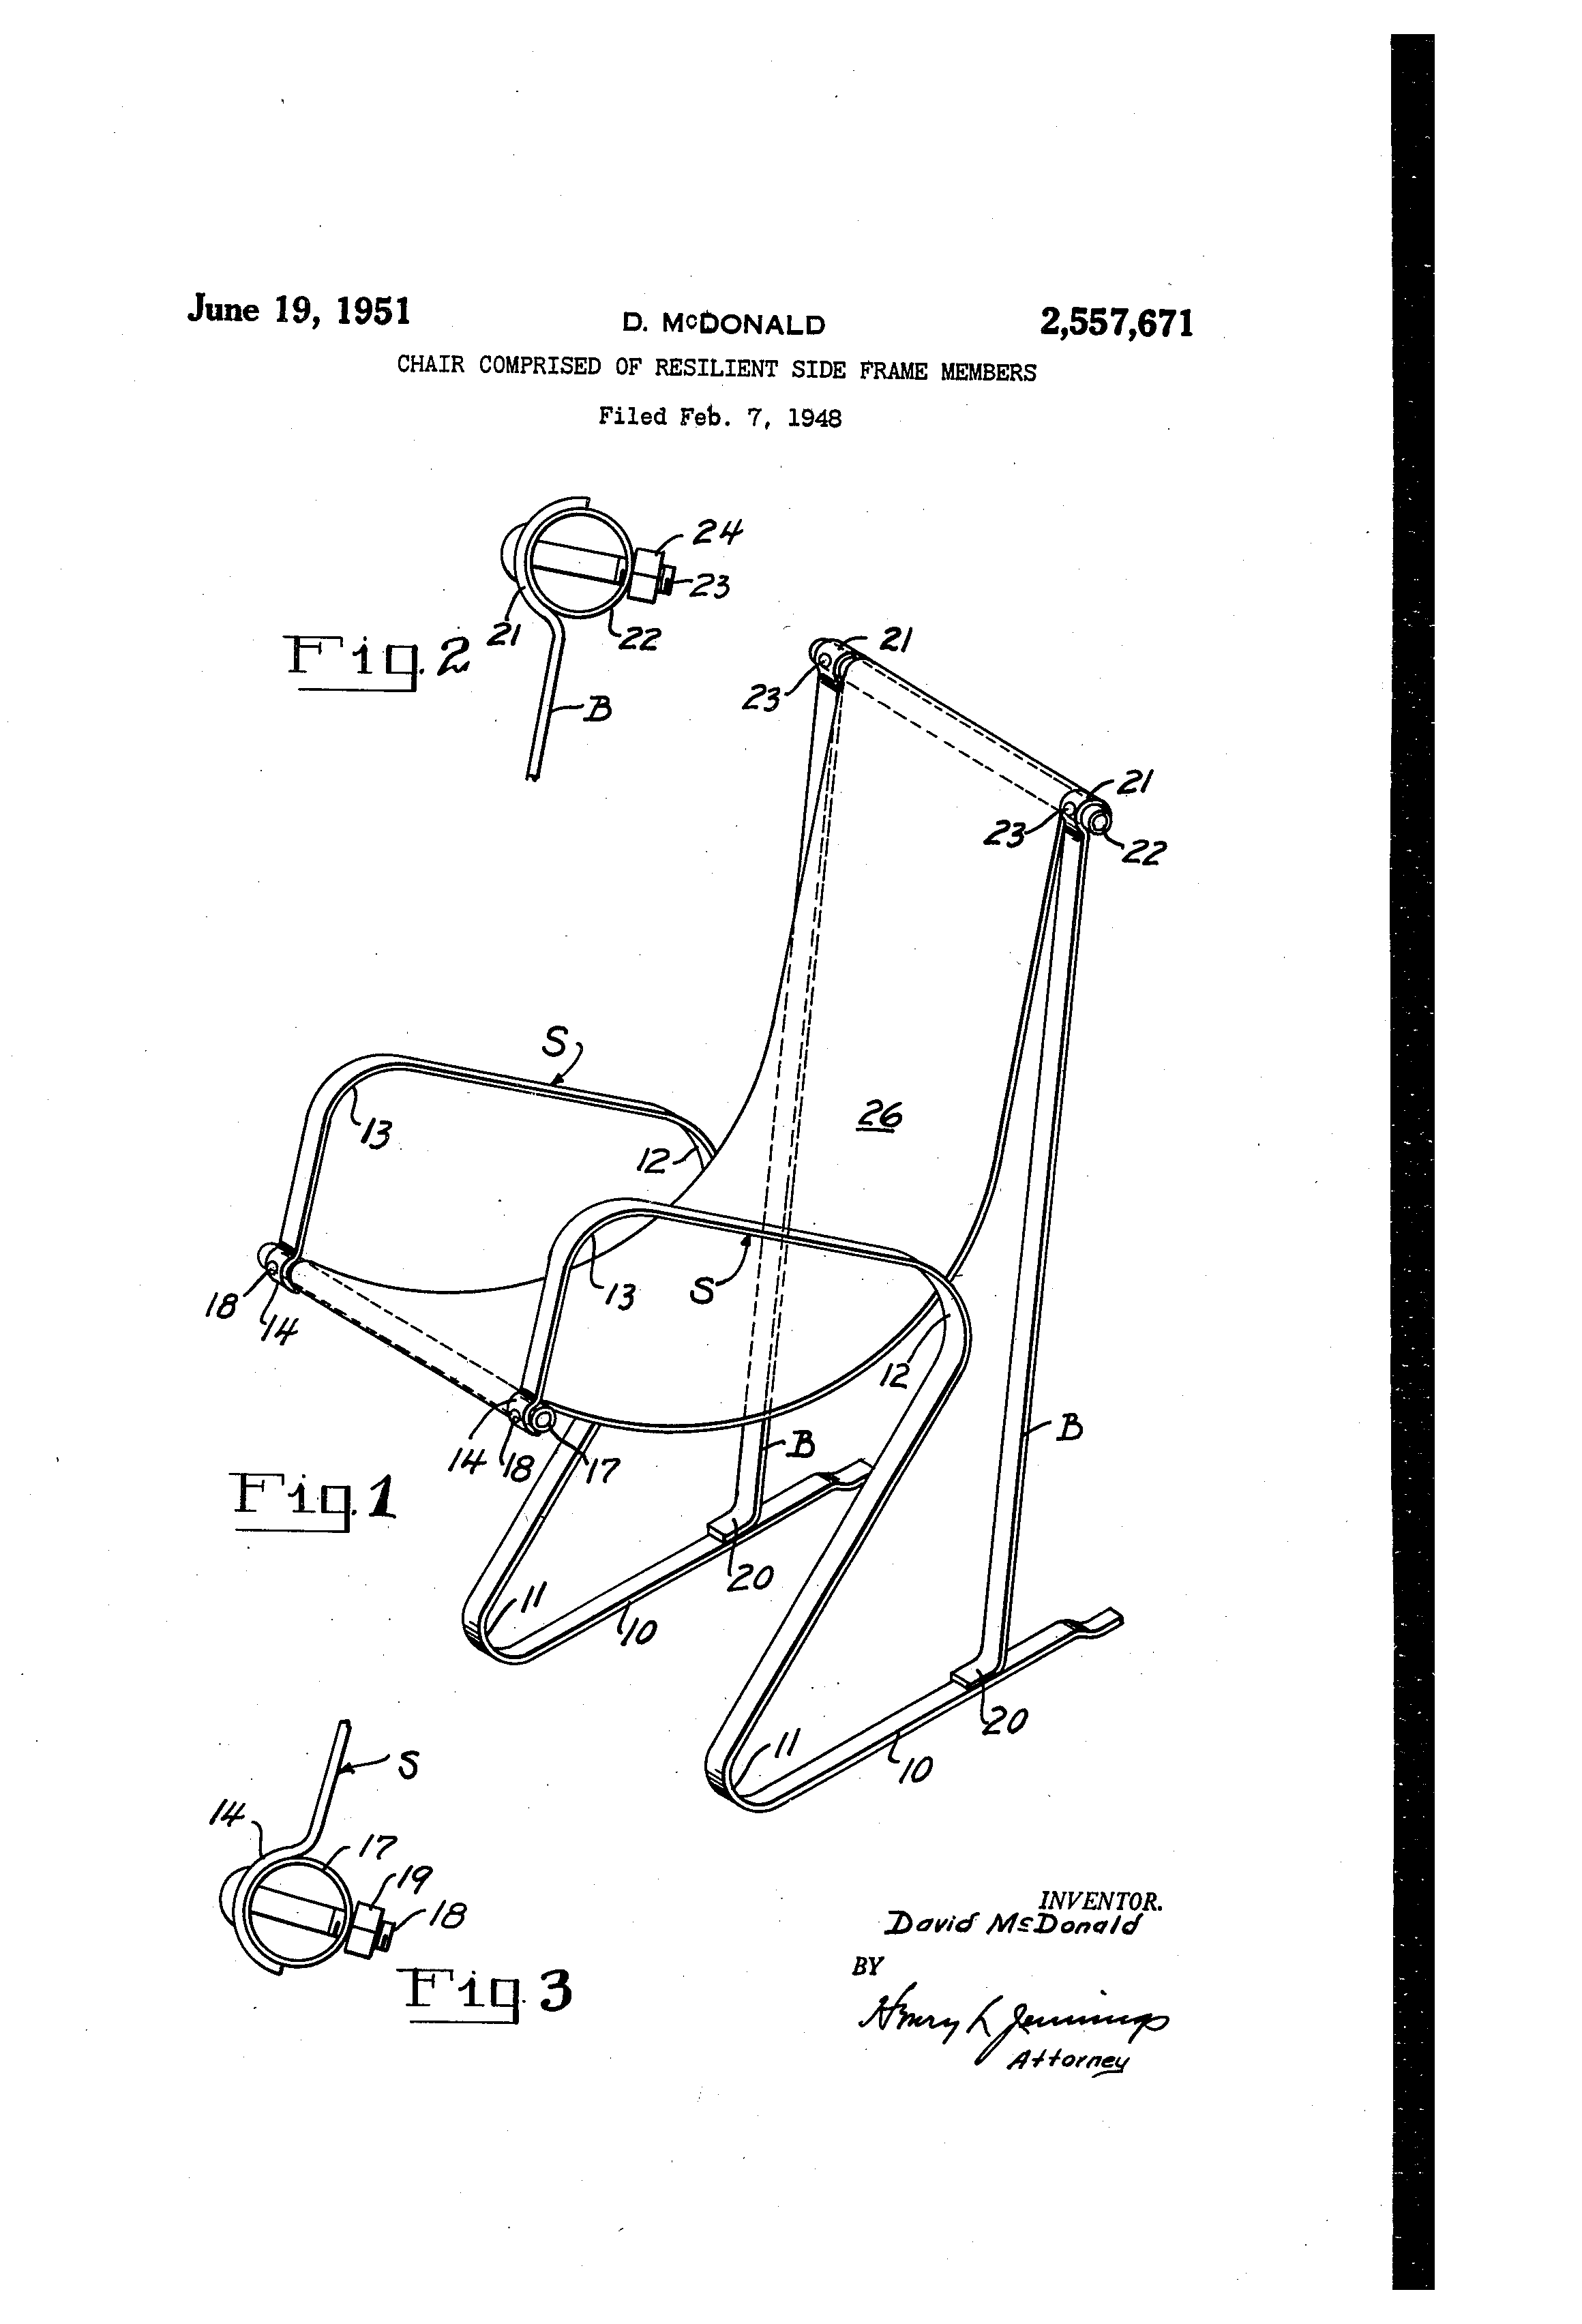

In [334]:
from IPython.display import Image as Img, display
display(Img(filename="extracted_images/image1_1.png",width=400,
    height=400))

# Getting an image description from pretrained 

https://huggingface.co/Salesforce/blip-image-captioning-base

In [324]:
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

raw_image = Image.open("extracted_images/image1_1.png") # .convert('RGB')

# conditional image captioning
text = "picture of"
inputs = processor(raw_image, text, return_tensors="pt")

out = model.generate(**inputs)
description = processor.decode(out[0], skip_special_tokens=True)

inputs = processor(raw_image, return_tensors="pt")

out = model.generate(**inputs)
description2 = processor.decode(out[0], skip_special_tokens=True)

# this could be sped up if necessary 

In [326]:
description

'picture of the original patent for the chair'

In [327]:
description2

'patent for a chair'

# Find the most important word

In [321]:
# Load English tokenizer, tagger, parser and NER
nlp = spacy.load("en_core_web_sm")

doc = nlp(text)

# Find named entities, phrases and concepts

nouns = [token.lemma_ for token in doc if token.pos_ == "NOUN" if token.lemma_ not in ['picture', 'patent', 'application','icon','logo']]

if nouns==[]:
    entities = [entity.text for entity in doc.ents]
    nouns = entities
# https://realpython.com/natural-language-processing-spacy-python/

In [322]:
nouns

['chair']

In [323]:
keyword = nouns[0]
keyword

'chair'

# Pull text from PDF

In [300]:
doc = fitz.open('US2557671.pdf')
text = ""
for page in doc:
    text+=page.get_text()
text = ' '.join(text.split()).lower()
relevant = []

for t in text.split('. '):
    if keyword in t:
        relevant.append(t)
        
# https://neurondai.medium.com/how-to-extract-text-from-a-pdf-using-pymupdf-and-python-caa8487cf9d


# Counting Noun dependencies

- not my code , but it words

In [301]:
dependency = []
for txt in relevant:
    doc = nlp(txt)

    chunks = []
    for chunk in doc.noun_chunks:
        out = {}
        root = chunk.root
        out[root.pos_] = root
        for tok in chunk:
            if tok != root:
                out[tok.pos_] = tok
        chunks.append(out)
    
    count = 0
    for chunk in chunks:
        if keyword in str(chunk):
            count += len(chunk)
    dependency.append(count)
    count = 0
# https://stackoverflow.com/questions/67821137/spacy-how-to-get-all-words-that-describe-a-noun

In [302]:
chart = pd.DataFrame(columns = [])
chart['RelevantText'] = relevant
chart['DependencyCount'] = dependency

In [303]:
chart.sort_values(by='DependencyCount',ascending=False)

,RelevantText,DependencyCount
2,"6,899 2 clains, this invention relates to chai...",5
7,the frame members constructed as described fle...,4
0,"mcdonald 2,557,671 chair comprised of resilien...",3
5,referring to the drawing for a better under st...,3
3,"in particular, my invention contemplates an im...",2
4,a chair enabodying features of my invention is...,2
6,the two clamps 4 each partially encircle a cro...,2
8,in a chair embodying opposed resilient side fr...,2
9,in a chair embodying a pair of resilient side ...,2
1,chair comspresed of reslent shade frawe webers...,1


In [304]:
chart['RelevantText'][2]

'6,899 2 clains, this invention relates to chairs and particularly to a chair constructed of resilient frame members with a suspended fabric seat and back and has for an object the provision of a chair of the character designated which shall be siriple and sturdy of design and construction, and which may be read ily disassembled for packaging and shipment and rea,ssembled for use'

# Things to try: Model fine tuning
 https://colab.research.google.com/github/huggingface/notebooks/blob/main/examples/image_captioning_blip.ipynb#scrollTo=FrGmatasn5-B
 https://pypi.org/project/blip-ci/    

In [305]:
# future improvements

# better image captioning
# better word relationships
# some kind of cool visualization with word and 